# Libraries

In [2]:
from pathlib import Path
import os
import sys
if str(Path.cwd().parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent))
from utils.crossvalidation import xval
from settings.paths import match_path, img_path, rf_path, bnn_path, flex_path
import pandas as pd
import matplotlib.pyplot as plt
from utils.preprocessing import create_bins, prep_data, rename_aper
from settings.columns import specz, calculate_colors, create_colors, list_feat
from utils.metrics import sigma, bias ,out_frac, rmse, mse
import warnings
import numpy as np
from utils.metrics import sigma, out_frac, bias, rmse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from cycler import cycler
from sklearn.model_selection import GridSearchCV
from utils.preprocessing import create_bins
from utils.crossvalidation import metric_per_bin
from utils.preprocessing import create_bins, prep_data, rename_aper

plt.rcParams["font.size"] = 22
blue = (0, 0.48, 0.70)
orange = (230/255,159/255, 0)
yellow = (0.94, 0.89, 0.26)
pink = (0.8, 0.47, 0.65)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.rcParams['axes.prop_cycle'] = cycler('color', CB_color_cycle)

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2


In [3]:
from utils.correct_extinction import correction
aper = "PStotal"

In [4]:
table = pd.read_table(os.path.join(match_path,"STRIPE82_DR2_DR16Q1a_unWISE2a_GALEXDR672a.csv"), sep=",")
table = rename_aper(table)

In [5]:
# table_corrected = correction(table)

In [6]:

feat_mag = list_feat(aper=aper, broad = True, narrow = True, galex = True, wise = True)
feat = create_colors(broad = True, narrow=True, wise=True, galex=True, aper=aper)
# data = table_corrected.copy(deep=True)
data = prep_data(table, rmax = 22, rmin = "None", zmax = 7, zmin = 0, val_mb = 99, aper=aper)
data = calculate_colors(data, broad = True, narrow= True, wise = True, galex= True, aper=aper)


In [7]:
mask_all = data[feat_mag]!=99
mask_all = mask_all.sum(axis=1)
data["nDet_all"] = mask_all

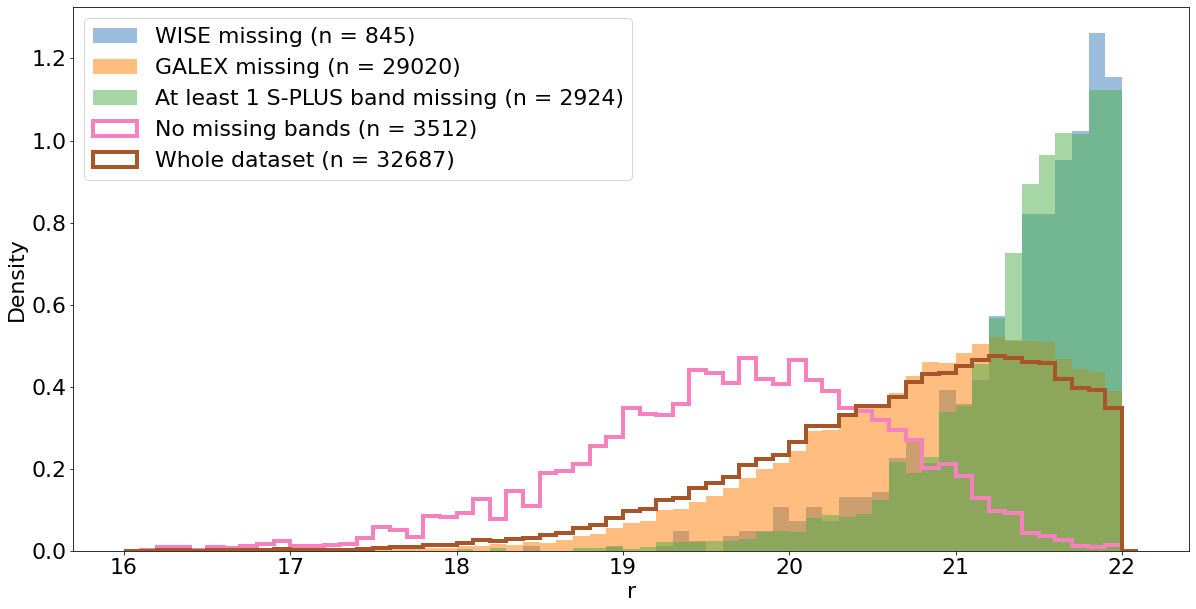

In [6]:
bins = np.arange(16,22.1,0.1)
fig, ax = plt.subplots(1,1, figsize=(20,10))

density = True
mask_WISE = ((data.W1_MAG==99) | (data.W2_MAG==99))
mask_GALEX = ((data.FUVmag==99) | (data.NUVmag==99))
mask_SPLUS9 = ((data.nDet_aper_3 < 11))
ax.hist(data[mask_WISE].r_PStotal, bins = bins, alpha=0.5, density = density, label="WISE missing (n = %s)" % mask_WISE.sum() )
ax.hist(data[mask_GALEX].r_PStotal, bins = bins, alpha=0.5, density = density, label="GALEX missing (n = %s)" % mask_GALEX.sum() )
ax.hist(data[mask_SPLUS9].r_PStotal, bins = bins, alpha=0.5, density = density, label="At least 1 S-PLUS band missing (n = %s)" % mask_SPLUS9.sum())

ax.hist(data[data["nDet_all"]==16].r_PStotal, bins=bins, histtype="step", density=density, label="No missing bands (n = %s)" % len(data[data["nDet_all"]==16]), linewidth = 4)
ax.hist(data.r_PStotal, bins=bins, histtype="step", density=density, label="Whole dataset (n = %s)" % len(data) , linewidth = 4)

ax.set_ylabel("Density")
ax.set_xlabel("r")
plt.legend()
plt.show()

In [9]:
data, bins, itvs = create_bins(data = data, bin_size=0.5, return_data = True, var = specz)
train, test = train_test_split(data, random_state=47, stratify=data['Zclass'])
zclass_train = train["Zclass"]
# print(train[feat_mag].describe())
train = correction(train)
# print(train[feat_mag].describe())
# print(test[feat_mag].describe())
test = correction(test)
# print(test[feat_mag].describe())

In [10]:
train.r_PStotal

0        21.596554
1        19.934259
2        20.596367
3        20.675332
4        20.451906
           ...    
24510    20.618339
24511    20.999532
24512    21.065954
24513    21.049988
24514    21.283643
Name: r_PStotal, Length: 24515, dtype: float64

In [11]:
test.r_PStotal

0       19.575076
1       20.674403
2       20.805466
3       21.050094
4       20.442962
          ...    
8167    21.658670
8168    20.664293
8169    21.760073
8170    19.302951
8171    20.790239
Name: r_PStotal, Length: 8172, dtype: float64

# Histogram train/test

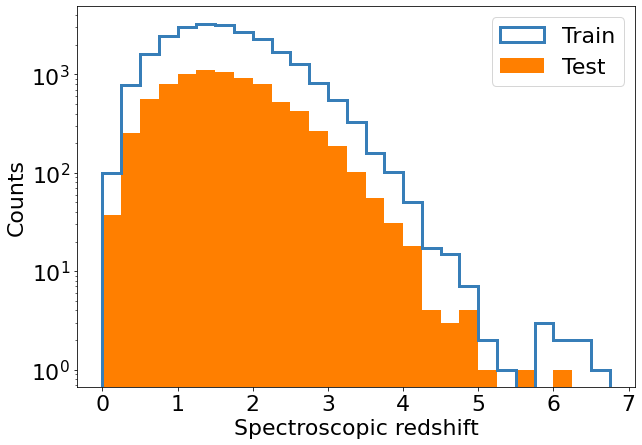

In [8]:
plt.figure(figsize=(10,7))
plt.hist(train.Z, bins = np.arange(0,7,0.25), log=True, histtype="step", linewidth=3, label="Train")
plt.hist(test.Z, bins = np.arange(0,7,0.25), log=True, label="Test")
plt.legend()
plt.xlabel("Spectroscopic redshift")
plt.ylabel("Counts")
plt.xticks([0,1,2,3,4,5,6,7])
# plt.savefig(os.path.join(img_path, "distribution_train_test.png"))
plt.show()


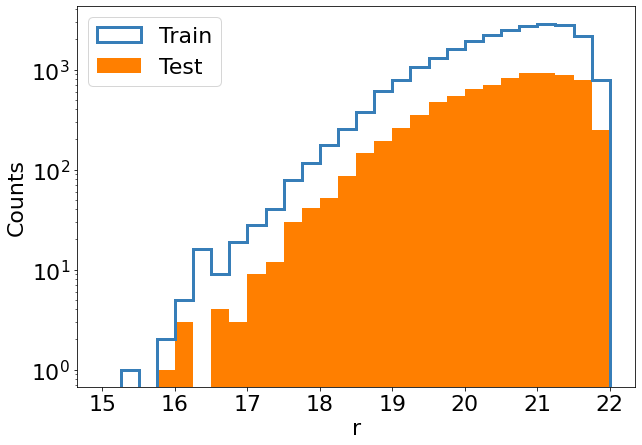

In [9]:
plt.figure(figsize=(10,7))
plt.hist(train.r_PStotal, bins = np.arange(15,22.1,0.25), log=True, histtype="step", linewidth=3, label="Train")
plt.hist(test.r_PStotal, bins = np.arange(15,22.1,0.25), log=True, label="Test")
plt.legend()
plt.xlabel("r")
plt.ylabel("Counts")
# plt.xticks([0,1,2,3,4,5,6,7])
# plt.savefig(os.path.join(img_path, "distribution_train_test_r.png"))
plt.show()


In [10]:
feat = {}
feat["broad"] =  create_colors(broad = True, narrow=False, wise=False, galex=False, aper=aper)
feat["broad+narrow"]=  create_colors(broad = True, narrow=True, wise=False, galex=False, aper=aper)
feat["broad+GALEX+WISE"]=  create_colors(broad = True, narrow=False, wise=True, galex=True, aper=aper)
feat["broad+GALEX+WISE+narrow"]=  create_colors(broad = True, narrow=True, wise=True, galex=True, aper=aper)

In [11]:
color_feat = {}
color_feat["broad"] = "#377eb8"
color_feat["broad+narrow"] =  "#ff7f00"
color_feat["broad+GALEX+WISE"]= "#4daf4a"
color_feat["broad+GALEX+WISE+narrow"]= "#f781bf"

# Fine tuning

In [79]:

param_grid = { 
    'n_estimators': [100, 200, 400],
    'bootstrap': [True, False],
    'max_depth' : [10,20,30, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}
model = RandomForestRegressor(random_state = 47)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=47)
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf)
CV.fit(train[feat["broad+GALEX+WISE+narrow"]], zclass_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=47, shuffle=True),
             estimator=RandomForestRegressor(random_state=47),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 400]})

In [80]:
CV.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

# Cross validation

bootstrap= True, max_depth= None, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 400

In [12]:
z={}
for key, value in feat.items():
    print(key)
    z[key] = xval(train, zclass_train , feat[key], key, aper=aper, save_model=True, save_result=False)


broad
broad+narrow
broad+GALEX+WISE
broad+GALEX+WISE+narrow


In [13]:
for key, value in feat.items():
    print(key)
    rmse_list = []
    sigma_list = []
    bias_list = []
    n30_list = []
    n15_list = []
    for fold in z[key].fold.unique():
        rmse_list.append(rmse(z[key][z[key]["fold"]==fold].z_pred, z[key][z[key]["fold"]==fold].Z))
        sigma_list.append(sigma(z[key][z[key]["fold"]==fold].z_pred, z[key][z[key]["fold"]==fold].Z))
        bias_list.append(bias(z[key][z[key]["fold"]==fold].z_pred, z[key][z[key]["fold"]==fold].Z))
        n30_list.append(out_frac(z[key][z[key]["fold"]==fold].z_pred, z[key][z[key]["fold"]==fold].Z, 0.3))
        n15_list.append(out_frac(z[key][z[key]["fold"]==fold].z_pred, z[key][z[key]["fold"]==fold].Z, 0.15))
    print('RMSE', np.round(np.mean(rmse_list),4), np.round(np.std(rmse_list),4))
    print('NMAD', np.round(np.mean(sigma_list),4),  np.round(np.std(sigma_list),4))
    print('bias', np.round(np.mean(bias_list),4),  np.round(np.std(bias_list),4))
    print('n15', np.round(np.mean(n15_list),4),  np.round(np.std(n15_list),4))
    print('n30', np.round(np.mean(n30_list),4),  np.round(np.std(n30_list),4))
    

broad
RMSE 0.656 0.0042
NMAD 0.2214 0.0016
bias -0.0005 0.0055
n15 0.4993 0.0032
n30 0.2193 0.0045
broad+narrow
RMSE 0.588 0.0047
NMAD 0.1866 0.0029
bias -0.0016 0.0033
n15 0.4353 0.0049
n30 0.1661 0.0021
broad+GALEX+WISE
RMSE 0.4518 0.008
NMAD 0.1069 0.0016
bias 0.0012 0.0026
n15 0.2414 0.0022
n30 0.0713 0.0035
broad+GALEX+WISE+narrow
RMSE 0.4382 0.0081
NMAD 0.097 0.001
bias -0.0009 0.0012
n15 0.2309 0.0031
n30 0.0656 0.0027


In [ ]:
# z = xval(train, zclass_train , feat["broad+narrow+galex+wise"], "broad+narrow+galex+wise", aper=aper, save_model=True)


In [14]:
z = {}
for key, value in feat.items():
    z[key] = pd.read_table(os.path.join(rf_path, "ext_z<7", "z_"+key+".csv"), sep=",", index_col=0)
    # idx = z[key].query("fold==0")
    # aux = pd.DataFrame(data.loc[z[key].index].g_PStotal, columns=["g_PStotal"])
    # aux.index = z[key].index
    # z[key] = pd.concat([z[key], aux], axis=1)

# Plot residuals

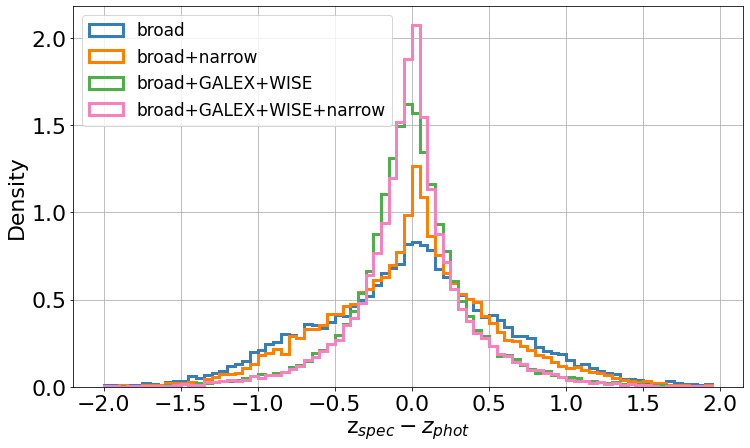

In [14]:
plt.figure(figsize=(12,7))
bins = np.arange(-2,2,0.05)
for key, model in feat.items():
    plt.hist(z[key].Z - z[key].z_pred, bins = bins,  zorder=10,alpha=1, histtype="step" , linewidth=3, label= key, density=True)
plt.grid(zorder=0)
plt.ylabel("Density")
plt.xlabel(r"z$_{spec}-z_{phot}$")
plt.legend(prop={'size': 17}, loc="upper left")
plt.savefig(os.path.join(img_path,"residuals_all.png"))
# plt.ylim(0,2.2)
plt.show()

# Plot per bin

In [2]:
from utils.plots import plot_metric_per_bin, metrics_bin

In [12]:
from utils.preprocessing import create_bins
# bins_r, itv_r = create_bins(z["broad"], return_data = False, var = "g-r", bin_size=0.01, bins= bins)
    

In [13]:
# idx = train.query("W1_MAG!=99 or W2_MAG != 99").index
idx = train.index

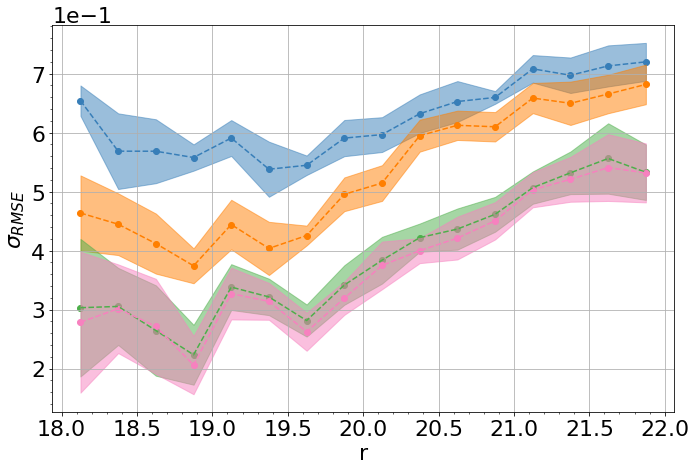

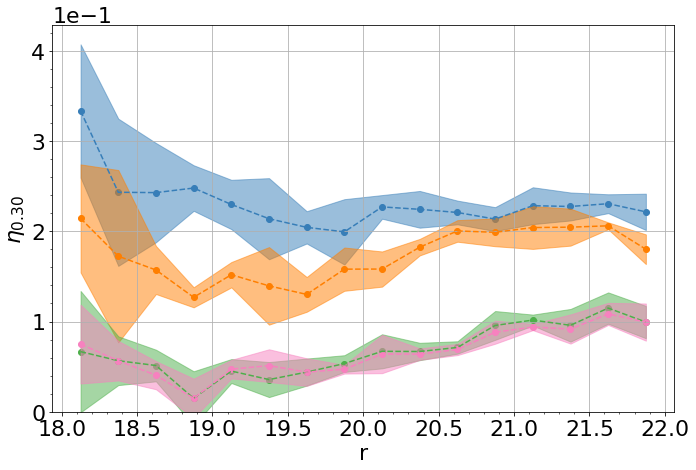

In [41]:
from utils.plots import plot_metric_per_bin
list_feat = ["broad", "broad+narrow", "broad+GALEX+WISE", "broad+GALEX+WISE+narrow"]
# list_feat = ["broad+galex+wise", "broad+narrow+galex+wise"]
# list_feat = ["broad", "broad+narrow"]
std=True
bins = np.arange(18, 22.2, 0.25)
plot_metric_per_bin(list_feat,z, rmse, color_feat = color_feat, std=std, bins = bins, save=True, idx = idx)
plot_metric_per_bin(list_feat,z, out_frac, color_feat = color_feat,  std=std, bins = bins, save=True, idx = idx)
# plot_metric_per_bin(list_feat,z, bias, color_feat = color_feat,  std=std, bins = bins, save=True, idx = idx)
# plot_metric_per_bin(list_feat,z, sigma, color_feat = color_feat,  std=std, bins = bins, save=True, idx = idx)

# bins = np.arange(-1., 3, 0.25)
# plot_metric_per_bin(list_feat,z, rmse, color_feat = color_feat,  std=std, bins = bins, save=True, per="g-r", idx = idx)
# plot_metric_per_bin(list_feat,z, out_frac, color_feat = color_feat,  std=std, bins = bins, save=True, per="g-r", idx = idx)
# plot_metric_per_bin(list_feat,z, bias, color_feat = color_feat,  std=std, bins = bins, save=True, per="g-r", idx = idx)
# plot_metric_per_bin(list_feat,z, sigma, color_feat = color_feat,  std=std, bins = bins, save=True, per="g-r", idx = idx)

# bins = np.arange(0.5, 5.2, 0.25)
# plot_metric_per_bin(list_feat,z, rmse, color_feat = color_feat,  std=std, bins = bins, save=True, per="Z", idx = idx)
# plot_metric_per_bin(list_feat,z, out_frac, color_feat = color_feat,  std=std, bins = bins, save=True, per="Z", idx = idx)
# plot_metric_per_bin(list_feat,z, bias, color_feat = color_feat,  std=std, bins = bins, save=True, per="Z", idx = idx)
# plot_metric_per_bin(list_feat,z, sigma, color_feat = color_feat,  std=std, bins = bins, save=True, per="Z", idx = idx)



# Test

In [339]:
import pickle
model = {}
for space in ["broad+GALEX+WISE+narrow", "broad+GALEX+WISE"]:
    model[space] = RandomForestRegressor(random_state = 47, bootstrap= True, max_depth= 20, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 400)
    model[space].fit(train[feat[space]],train.Z)
    # mag = pd.DataFrame(test["r_"+aper], columns={"r_"+aper})
    # mag["g_"+aper] = test["g_"+aper]
    # mag["g-r"] = mag["g_"+aper] - mag["r_"+aper]
    # z_p = pd.DataFrame(model[space].predict(test[feat[space]]), index=test.index, columns=["z_pred"])
    # z_val = pd.DataFrame(test.Z)
    # z_aux = pd.concat([z_p,z_val, mag], axis = 1)
    # z_aux.to_csv(os.path.join(rf_path,"test_z_"+space+".csv"), index=True)
    pickle.dump(model[space], open(os.path.join(rf_path, "ext_z<7", "RF_train_"+space+".sav"), "wb"))

In [62]:
z_test = {}

for space in ["broad+GALEX+WISE+narrow", "broad+GALEX+WISE"]:
    z_test[space] = pd.read_csv(os.path.join(rf_path,"ext_z<7", "test_z_"+space+".csv"), sep=",", index_col = 0)

In [63]:
# After extinction
for key in ["broad+GALEX+WISE+narrow", "broad+GALEX+WISE"]:
    print(key)
    print('RMSE', np.round(rmse(z_test[key].z_pred,z_test[key].Z),4))
    print('NMAD', np.round(sigma(z_test[key].z_pred,z_test[key].Z),4))
    print('bias', np.round(bias(z_test[key].z_pred,z_test[key].Z),4))
    print('n30', np.round(out_frac(z_test[key].z_pred,z_test[key].Z, 0.30),4))
    print('n15', np.round(out_frac(z_test[key].z_pred,z_test[key].Z, 0.15),4))

broad+GALEX+WISE+narrow
RMSE 0.439
NMAD 0.0952
bias 0.0419
n30 0.0675
n15 0.2266
broad+GALEX+WISE
RMSE 0.4564
NMAD 0.1023
bias 0.0403
n30 0.0718
n15 0.2427


In [53]:
len(test)

8172

# Compare methods

In [18]:
from settings.paths import validation_path
z_test = {}
z_rf = {}
z_flex = {}
z_bnn = {}
test = pd.read_table(os.path.join(validation_path,"ext_test.csv"), sep=",", index_col=0)
for space in ["broad+GALEX+WISE+narrow", "broad+GALEX+WISE"]:
    filename_rf = os.path.join(rf_path,"ext_z<7", "test_z_"+space+".csv")
    filename_flex = os.path.join(flex_path, "ext_z<7", "test_z_"+space+".csv")
    
    z_rf[space] = pd. read_table(filename_rf, sep=",", index_col=0)
    z_flex[space] = pd.read_table(filename_flex, sep=",")
    
    z_flex[space].index = test.index
    z_rf[space].index = test.index
    
filename_bnn = os.path.join(bnn_path, "crossval_model-ext-nb", "Results_DF.csv")
z_bnn["broad+GALEX+WISE+narrow"] = pd.read_table(filename_bnn, sep=",")
z_bnn["broad+GALEX+WISE+narrow"].index = test.index
filename_bnn = os.path.join(bnn_path, "crossval_model-ext-nonb", "Results_DF.csv")
z_bnn["broad+GALEX+WISE"] = pd.read_table(filename_bnn, sep=",")
z_bnn["broad+GALEX+WISE"].index = test.index
for space in ["broad+GALEX+WISE+narrow", "broad+GALEX+WISE"]:
    z_test[space]=pd.DataFrame()
    z_test[space]["z_rf"] = z_rf[space].z_pred
    z_test[space]["z_flex"] = z_flex[space].z_flex_peak
    z_test[space]["z_bnn"] = z_bnn[space].zphot
    z_test[space]["z_mean"] = (z_test[space]["z_rf"]+z_test[space]["z_bnn"]+z_test[space]["z_flex"])/3
    z_test[space]["Z"] = z_rf[space].Z
    z_test[space]["r_PStotal"] = test.r_PStotal
    z_test[space]["g_PStotal"] = test.g_PStotal
    z_test[space]["g-r"] = test.g_PStotal-test.r_PStotal
    z_test[space] = z_test[space].query("Z<5")

In [46]:
# mask_WISE = ((test.W1_MAG==99) | (test.W2_MAG==99))
# idx_WISE = test.query("Z<5")[mask_WISE].index_col

# mask_GW = ((test.W1_MAG==99) | (test.W2_MAG==99) | (test.FUVmag==99) | (test.NUVmag==99))
# idx_GW = test.query("Z<5")[mask_GW].index

# for space in ["broad+narrow+galex+wise", "broad+GALEX+WISE"]:
#     print(space)

for column in ["z_rf", "z_bnn", "z_flex", "z_mean"]:
    print(column)
    print("broad+narrow+galex+wise |  broad+galex+wise")
    print('RMSE', np.round(rmse(z_test["broad+GALEX+WISE+narrow"]["Z"],z_test["broad+GALEX+WISE+narrow"][column]),4),  np.round(rmse(z_test["broad+GALEX+WISE"]["Z"],z_test["broad+GALEX+WISE"][column]),4))
    # print('RMSE no GW', np.round(rmse(z_test["broad+GALEX+WISE+narrow"].loc[idx_GW]["Z"],z_test["broad+GALEX+WISE+narrow"].loc[idx_GW][column]),4), np.round(rmse(z_test["broad+GALEX+WISE"].loc[idx_GW]["Z"],z_test["broad+GALEX+WISE"].loc[idx_GW][column]),4))
    print('NMAD', np.round(sigma(z_test["broad+GALEX+WISE+narrow"]["Z"],z_test["broad+GALEX+WISE+narrow"][column]),4), np.round(sigma(z_test["broad+GALEX+WISE"]["Z"],z_test["broad+GALEX+WISE"][column]),4))
    # print('NMAD no GW', np.round(sigma(z_test["broad+GALEX+WISE+narrow"].loc[idx_GW]["Z"],z_test["broad+GALEX+WISE+narrow"].loc[idx_GW][column]),4),  np.round(sigma(z_test["broad+GALEX+WISE"].loc[idx_GW]["Z"],z_test["broad+GALEX+WISE"].loc[idx_GW][column]),4))
    print('bias', np.round(bias(z_test["broad+GALEX+WISE+narrow"]["Z"],z_test["broad+GALEX+WISE+narrow"][column]),4), np.round(bias(z_test["broad+GALEX+WISE"]["Z"],z_test["broad+GALEX+WISE"][column]),4))
    # print('bias no GW', np.round(bias(y_pred=z_test["broad+GALEX+WISE+narrow"].loc[idx_GW]["Z"],y=z_test["broad+GALEX+WISE+narrow"].loc[idx_GW][column]),4), np.round(bias(y_pred=z_test["broad+GALEX+WISE"].loc[idx_GW]["Z"],y=z_test["broad+GALEX+WISE"].loc[idx_GW][column2]),4))
    print('n15', np.round(out_frac(z_test["broad+GALEX+WISE+narrow"]["Z"],z_test["broad+GALEX+WISE+narrow"][column], 0.15),4), np.round(out_frac(z_test["broad+GALEX+WISE"]["Z"],z_test["broad+GALEX+WISE"][column], 0.15),4))
    # print('n15 no GW', np.round(out_frac(z_test["broad+GALEX+WISE+narrow"].loc[idx_GW]["Z"],z_test["broad+GALEX+WISE+narrow"].loc[idx_GW][column], 0.15),4), np.round(out_frac(z_test["broad+GALEX+WISE"].loc[idx_GW]["Z"],z_test["broad+GALEX+WISE"].loc[idx_GW][column], 0.15),4))
    print('n30', np.round(out_frac(z_test["broad+GALEX+WISE+narrow"]["Z"],z_test["broad+GALEX+WISE+narrow"][column], 0.30),4), np.round(out_frac(z_test["broad+GALEX+WISE"]["Z"],z_test["broad+GALEX+WISE"][column], 0.30),4))
    # print('n30 no GW', np.round(out_frac(z_test["broad+GALEX+WISE+narrow"].loc[idx_GW]["Z"],z_test["broad+GALEX+WISE+narrow"].loc[idx_GW][column], 0.30),4), np.round(out_frac(z_test["broad+GALEX+WISE"].loc[idx_GW]["Z"],z_test["broad+GALEX+WISE"].loc[idx_GW][column], 0.30),4))


z_rf
broad+narrow+galex+wise |  broad+galex+wise
RMSE 0.4239 0.4408
NMAD 0.0958 0.1033
bias -0.0447 -0.0432
n15 0.2374 0.2504
n30 0.0814 0.0849
z_bnn
broad+narrow+galex+wise |  broad+galex+wise
RMSE 0.4542 0.4841
NMAD 0.053 0.0891
bias 0.017 0.0354
n15 0.2104 0.2308
n30 0.0736 0.0871
z_flex
broad+narrow+galex+wise |  broad+galex+wise
RMSE 0.4719 0.4985
NMAD 0.0416 0.0876
bias 0.0174 0.0462
n15 0.218 0.2386
n30 0.0869 0.0923
z_mean
broad+narrow+galex+wise |  broad+galex+wise
RMSE 0.4062 0.4347
NMAD 0.0636 0.0914
bias -0.0034 0.0128
n15 0.2 0.2191
n30 0.064 0.073


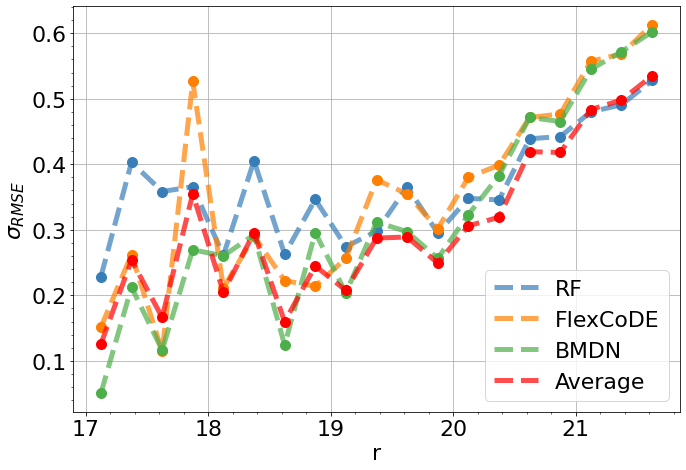

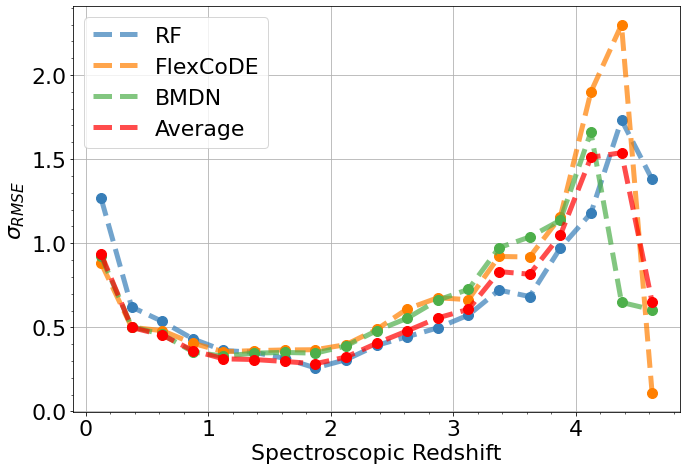

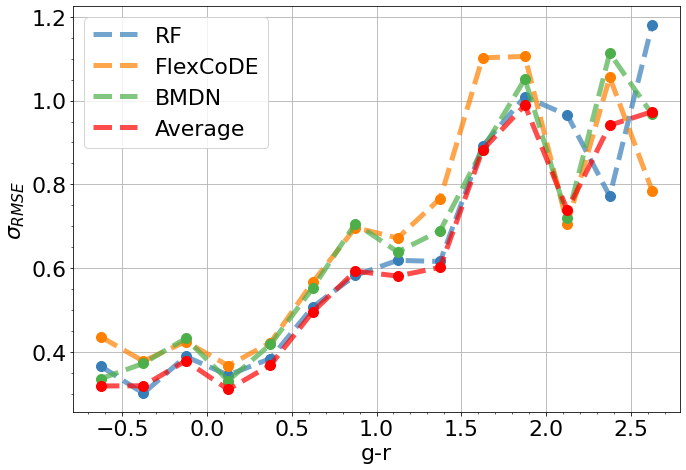

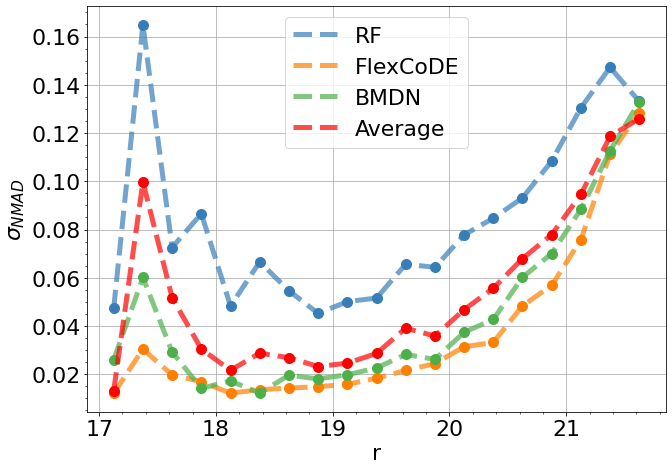

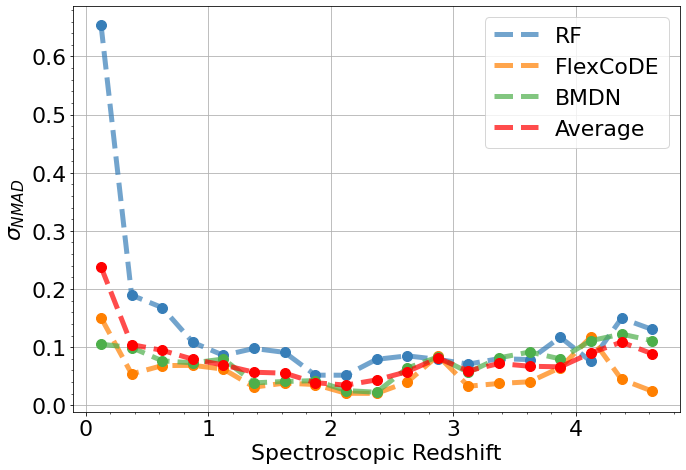

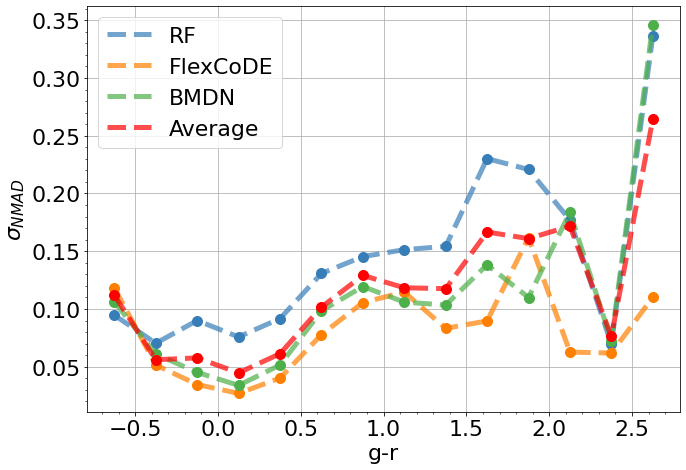

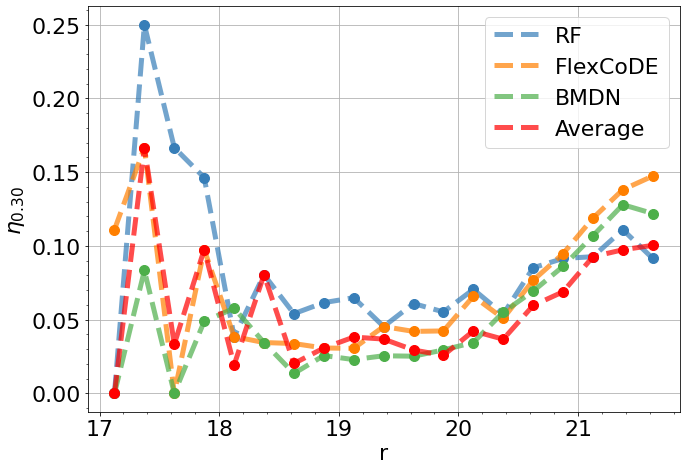

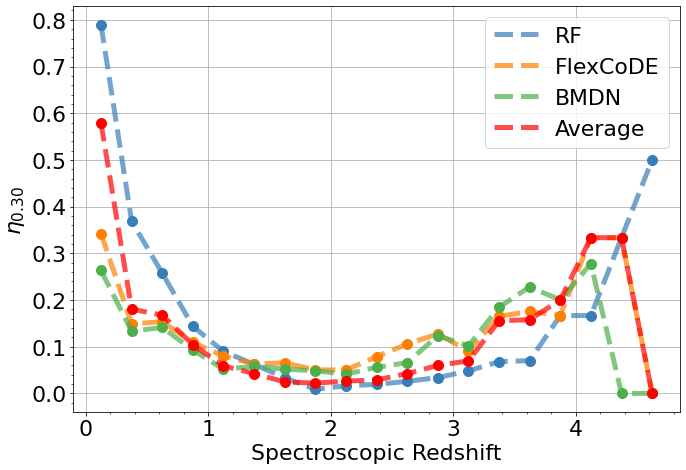

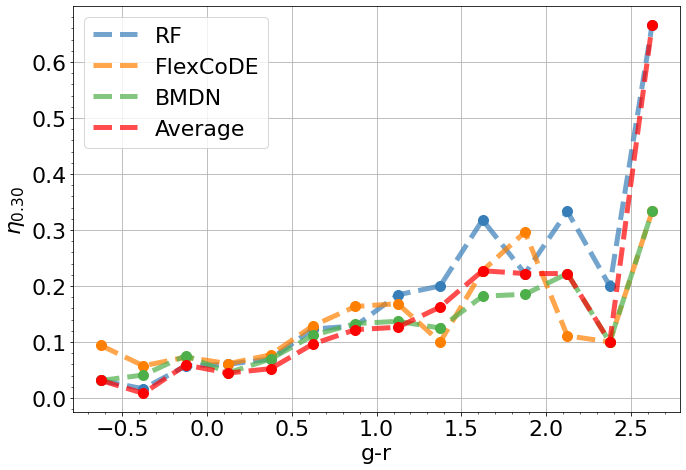

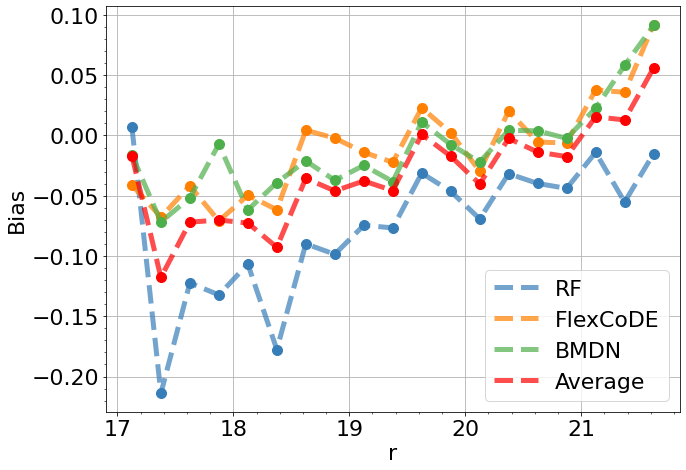

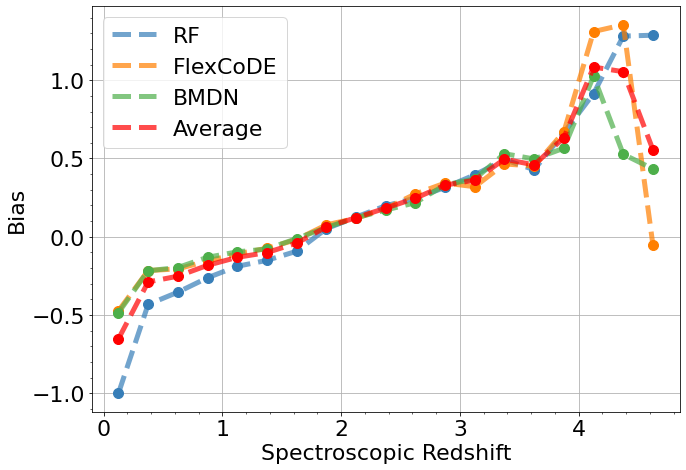

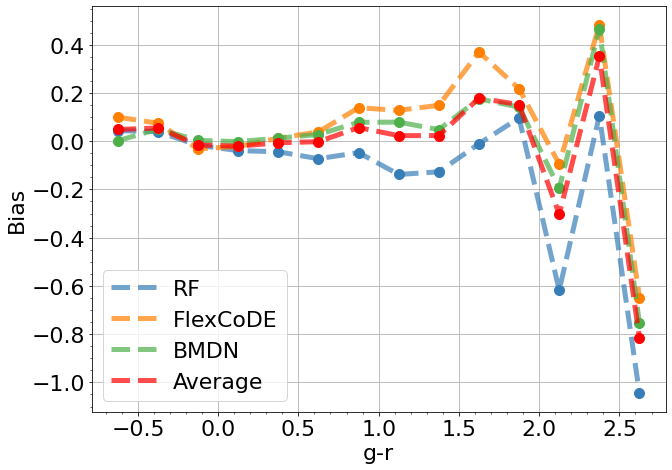

In [170]:
list_metric = [rmse, sigma, out_frac, bias]
list_var = ["r_PStotal", "Z", "g-r"]
z_no99 = z_test["broad+GALEX+WISE+narrow"].query("r_PStotal!=99 and g_PStotal!=99")
# z_no99 = z_test["broad+GALEX+WISE+narrow"].query("r_PStotal!=99")
df_output = {}
for metric in list_metric:
    for var in list_var:
        if var == "r_PStotal":
            bins = np.arange(17,22,0.25)
        elif var =="Z":
            bins = np.arange(0,5,0.25)
        else:
            bins = np.arange(-1., 3, 0.25)

        bins_r, itv_r = create_bins(z_no99, return_data = False, var = var, bins= bins)
        bin_size = bins_r[1] - bins_r[0]
        half_bins = np.arange(bins_r[0]+(bin_size/2), bins_r[-1]+bin_size/2, bin_size)
        output_rf = metric_per_bin(metric = metric, z = z_no99, itvs = itv_r, column = "z_rf")
        output_bnn = metric_per_bin(metric = metric, z = z_no99, itvs = itv_r, column = "z_bnn")
        output_flex = metric_per_bin(metric = metric, z = z_no99, itvs = itv_r, column = "z_flex")
        output_mean = metric_per_bin(metric = metric, z = z_no99, itvs = itv_r, column = "z_mean")
        key = metric.__name__+"_"+var
        df_output[key] = pd.DataFrame([output_rf, output_bnn, output_flex, output_mean, half_bins])
        df_output[key] = df_output[key].T
        df_output[key].columns = ["rf", "bnn", "flex", "mean", "bins"]
        # df_output[key]["rf_norm"] = df_output[key]["rf"]/df_output[key]["mean"]
        # df_output[key]["bnn_norm"] = df_output[key]["bnn"]/df_output[key]["mean"]
        # df_output[key]["flex_norm"] = df_output[key]["flex"]/df_output[key]["mean"]
        df_output[key]["rf_norm"] = df_output[key]["rf"]
        df_output[key]["bnn_norm"] = df_output[key]["bnn"]
        df_output[key]["flex_norm"] = df_output[key]["flex"]
        fig, ax = plt.subplots(1,1, figsize=(10,7))
        s=100
        ax.scatter(half_bins,df_output[key]["rf_norm"], s=s, zorder=1000)
        ax.plot(half_bins,df_output[key]["rf_norm"], '--', label="RF", linewidth=5, alpha=0.7, zorder=1000)
        ax.scatter(half_bins,df_output[key]["flex_norm"], s=s, zorder=1000)
        ax.plot(half_bins,df_output[key]["flex_norm"], '--', label="FlexCoDE", linewidth=5, alpha=0.7, zorder=1000)
        ax.scatter(half_bins,df_output[key]["bnn_norm"], s=s, zorder=1000)
        ax.plot(half_bins,df_output[key]["bnn_norm"], '--', label="BMDN", linewidth=5, alpha=0.7, zorder=1000)
        ax.scatter(half_bins,output_mean, s=s, zorder=1000, color="red")
        ax.plot(half_bins,output_mean, '--', label="Average", linewidth=5, alpha=0.7, zorder=1000, color="red")
        # ax.axhline(y=1, color="red", linewidth=3, label="Average")
        ax.grid()
        if metric.__name__ == "rmse":
            ax.set_ylabel(r"$\sigma_{RMSE}$")
        elif metric.__name__ == "out_frac":
            ax.set_ylabel(r"$\eta_{0.30}$")
            # plt.gca().set_ylim(bottom=0)
        elif metric.__name__ == "bias":
            ax.set_ylabel("Bias")
            # plt.axhline(0, color="gray", linewidth=2, zorder=1)
        elif metric.__name__ == "mse":
            ax.set_ylabel("MSE")
        else:
            ax.set_ylabel(r"$\sigma_{NMAD}$")   

        if var == "r_PStotal":
            ax.set_xlabel("r")
        elif var =="Z":
            ax.set_xlabel("Spectroscopic Redshift")
        else:
            ax.set_xlabel("g-r")    
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(img_path, metric.__name__+"_"+var+"_allmodels.png"))
        plt.show()

# Feature importances

In [47]:
import pickle
imp = pd.DataFrame()
for fold in ["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"]:
    file = open(os.path.join(rf_path,"ext_z<7", "RF_broad+GALEX+WISE+narrow"+fold+".sav"),'rb')
    imp[fold] = pickle.load(file).feature_importances_

In [48]:

feat_plot = [r'$u-r$',
r'$g-r$',
r'$r-i$',
r'$r-z$',
r'$J0378-r$',
r'$J0395-r$',
r'$J0410-r$',
r'$J0430-r$',
r'$J0515-r$',
r'$r-J0660$',
r'$r-J0861$',
r'$r-W1$',
r'$r-W2$',
r'$FUV-r$',
r'$NUV-r$']

In [49]:
imp_xval = pd.DataFrame()
imp_xval["mean"] = imp.mean(1)
imp_xval["std"] = imp.std(1)
imp_xval["feat"] = feat_plot

In [50]:
imp_xval = imp_xval.sort_values(by="mean", ascending=False)

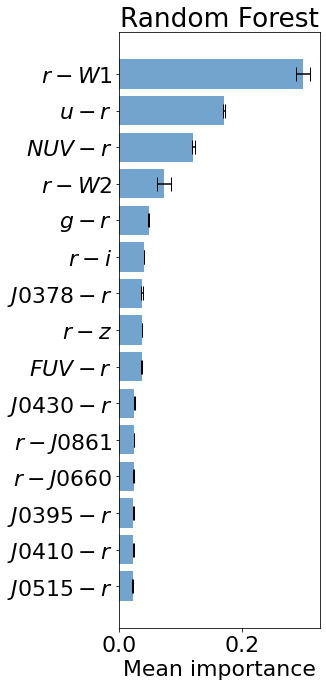

In [51]:

fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.barh(imp_xval.feat, imp_xval["mean"], xerr=imp_xval["std"], 
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=7)
# ax.set_xticklabels(feat_plot, rotation = 45)
ax.set_xlabel("Mean importance")
plt.minorticks_off()
plt.title("Random Forest")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.savefig(os.path.join(img_path,"importance_rf.png"))
plt.show()

In [226]:
imp_flex = pd.read_table(os.path.join(flex_path,"ext_z<7",  "mean_importances.csv"), sep=",",  index_col=0)

In [227]:
feat_flex = [r'$r-W1$', r'$u-r$', r'$J0378-r$',
       r'$r-i$', r'$r-J0660$', r'$g-r$',
       r'$J0410-r$', r'$J0430-r$',
       r'$J0515-r$', r'$J0395-r$',
       r'$r-W2$', r'$r-z$', r'$NUV-r$',
       r'$r-J0861$', r'$FUV-r$']

In [228]:
imp_flex["feat"] = feat_flex

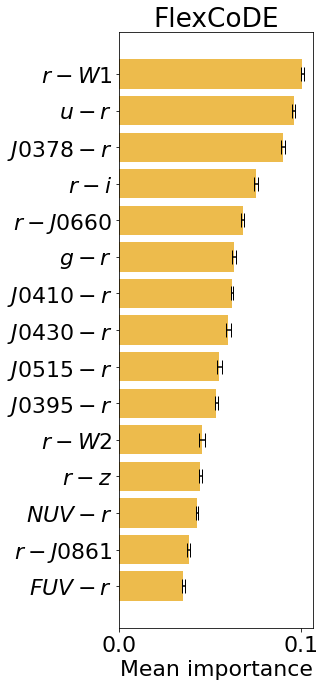

In [229]:
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.barh(imp_flex.feat, imp_flex["mean_frequency"], xerr=imp_flex["std_frequency"], 
       align='center',
       alpha=0.7,
       ecolor='black',
       color=orange,
       capsize=7)
# ax.set_xticklabels(feat_plot, rotation = 45)
ax.set_xlabel("Mean importance")
plt.minorticks_off()
plt.title("FlexCoDE")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.savefig(os.path.join(img_path, "importance_flex.png"))
plt.show()

## RF PDFs

In [10]:
import pickle
model = {}
for space in ["broad+GALEX+WISE+narrow", "broad+GALEX+WISE"]:
    file = open(os.path.join(rf_path,"ext_z<7", "RF_train_"+space+".sav"),'rb')
    model[space] = pickle.load(file)

In [18]:
grid_z = pd.read_table(os.path.join(flex_path, "ext_z<7", "z_grid.csv"), sep=",", index_col=0)
grid_z = grid_z.x.to_numpy()

In [365]:
step = grid_z[2]-grid_z[1]
grid_z = np.append(grid_z, grid_z[-1]+step) #has to add one more step to grid_z cause python dont consider the last element to create bins

In [368]:
pdf_rf = []
for i in np.arange(0,len(test)):
    trees = model["broad+GALEX+WISE"].estimators_
    # Get all tree predictions for the first instance
    pred = [tree.predict(np.array(test[feat["broad+GALEX+WISE"]].loc[i,]).reshape(1, -1))[0] for tree in trees]
    counts, bins = np.histogram(pred , bins=grid_z,density=True)
    pdf_rf.append(counts)
pdf_rf = pd.DataFrame(pdf_rf).loc[test.query("Z<5").index]
pdf_rf.to_csv(os.path.join(rf_path,"ext_z<7", "pdf_test_broad.csv"))

In [369]:
pdf_rf = []
for i in np.arange(0,len(test)):
    trees = model["broad+GALEX+WISE+narrow"].estimators_
    # Get all tree predictions for the first instance
    pred = [tree.predict(np.array(test[feat["broad+GALEX+WISE+narrow"]].loc[i,]).reshape(1, -1))[0] for tree in trees]
    counts, bins = np.histogram(pred , bins=grid_z,density=True)
    pdf_rf.append(counts)
pdf_rf = pd.DataFrame(pdf_rf).loc[test.query("Z<5").index]
pdf_rf.to_csv(os.path.join(rf_path,"ext_z<7", "pdf_test_narrow.csv"))

# RF checking mean x peak

In [12]:
pdf_narrow = pd.read_table(os.path.join(rf_path,"ext_z<7", "pdf_test_narrow.csv"), sep=",",index_col=0)

In [16]:
pdf_narrow

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071673,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.071673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
grid_z

array([0.058     , 0.09288041, 0.12776083, 0.16264124, 0.19752165,
       0.23240207, 0.26728248, 0.30216289, 0.33704331, 0.37192372,
       0.40680413, 0.44168455, 0.47656496, 0.51144537, 0.54632579,
       0.5812062 , 0.61608661, 0.65096703, 0.68584744, 0.72072785,
       0.75560827, 0.79048868, 0.82536909, 0.86024951, 0.89512992,
       0.93001033, 0.96489075, 0.99977116, 1.03465157, 1.06953199,
       1.1044124 , 1.13929281, 1.17417323, 1.20905364, 1.24393405,
       1.27881447, 1.31369488, 1.34857529, 1.38345571, 1.41833612,
       1.45321653, 1.48809695, 1.52297736, 1.55785777, 1.59273819,
       1.6276186 , 1.66249901, 1.69737943, 1.73225984, 1.76714025,
       1.80202067, 1.83690108, 1.87178149, 1.90666191, 1.94154232,
       1.97642273, 2.01130315, 2.04618356, 2.08106397, 2.11594439,
       2.1508248 , 2.18570521, 2.22058563, 2.25546604, 2.29034645,
       2.32522687, 2.36010728, 2.39498769, 2.42986811, 2.46474852,
       2.49962893, 2.53450935, 2.56938976, 2.60427017, 2.63915

## Outliers (Polsterer et at.)

In [ ]:
def Calc_PDF(x, Weights, Means, STDs):
    PDF = np.sum( Weights * (1/(STDs*np.sqrt(2*np.pi))) * np.exp((-1/2)*((x[:, None]-Means)**2)/(STDs)**2), axis=1 )
    return PDF/np.trapz(PDF, x)

In [ ]:
z_bnn.z

In [ ]:
z_bnn.head(1).PDF_Means.to_list()

In [ ]:
import scipy.stats as ss

prob_list = []
prob_range = []
for index, row in z_bnn.iterrows():
    x = row.z
    x_range = np.linspace(0,5,1000)
    y = np.zeros_like(x)
    y_range = np.zeros_like(x_range)
    means = [np.float(i) for i in (row.PDF_Means).split(',')]
    stds = [np.float(i) for i in (row.PDF_STDs).split(',')]
    weights = [np.float(i) for i in (row.PDF_Weights).split(',')]
    for l, s, w in zip(means, stds, weights):
        # print(l, s, w)
        y += ss.norm.pdf(x, loc=l, scale=s) * w
        y_range += ss.norm.pdf(x_range, loc=l, scale=s) * w

    prob_list = np.append(prob_list, y)
    prob_range = np.concatenate((prob_range, y_range))

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(prob_list, bins = 200)
plt.show()

In [ ]:
np.where(prob_list>3)

In [ ]:
prob_range = prob_range.reshape(8167,1000)

In [ ]:
np.trapz(prob_range[50],x_range)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

i=12
ax.plot(x_range, prob_range[i])
ax.axvline(z_bnn.iloc[i].z)

## Plot PIT

In [166]:
# (Aesthetically) Modified from: https://github.com/lee-group-cmu/cdetools/blob/master/python/src/cdetools/plot_utils.py

from scipy.stats import binom
from matplotlib import pyplot as plt
import numpy as np

def plot_with_uniform_band(values, ci_level, x_label, narrow=False,  n_bins=30, figsize=(10,4), ylim=[0, 50]):
    '''
    Plots the PIT/HPD histogram and calculates the confidence interval for the bin values, were the PIT/HPD values follow an uniform distribution

    @param values: a numpy array with PIT/HPD values
    @param ci_level: a float between 0 and 1 indicating the size of the confidence level
    @param x_label: a string, populates the x_label of the plot
    @param n_bins: an integer, the number of bins in the histogram
    @param figsize: a tuple, the plot size (width, height)
    @param ylim: a list of two elements, including the lower and upper limit for the y axis

    @returns The matplotlib figure object with the histogram of the PIT/HPD values and the CI for the uniform distribution
    '''

    # Extract the number of CDEs
    n = values.shape[0]

    # Creating upper and lower limit for selected uniform band
    ci_quantity = (1-ci_level)/2
    low_lim = binom.ppf(q=ci_quantity, n=n, p=1/n_bins)
    upp_lim = binom.ppf(q=ci_level + ci_quantity, n=n, p=1/n_bins)

    # Creating figure
    fig = plt.figure(figsize=figsize)
    if narrow:
        color = '#f781bf'
    else:
        color = '#4daf4a'
    plt.hist(values, bins=n_bins,
            edgecolor="white", color= color)
    plt.axhline(y=low_lim, color='grey')
    plt.axhline(y=upp_lim, color='grey')
    plt.axhline(y=n/n_bins, label='Uniform Average', color='red')
    plt.fill_between(x=np.linspace(0, 1, 100),
                     y1=np.repeat(low_lim, 100),
                     y2=np.repeat(upp_lim, 100),
                    color='grey', alpha=0.2)
    plt.legend(loc='best', prop={'size': 18})
    plt.xlabel(x_label, size=20)
    plt.ylim(ylim)
    plt.xlim(0,1)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.close()
    return fig

In [ ]:
pit_broad_flex = pd.read_table(os.path.join(flex_path, "ext_z<7", "pit_broad_flex.csv"), sep=",", index_col=0)
pit_narrow_flex = pd.read_table(os.path.join(flex_path, "ext_z<7", "pit_narrow_flex.csv"), sep=",", index_col=0)
pit_broad_bnn= pd.read_table(os.path.join(bnn_path, "crossval_model-ext-nonb", "Results_DF.csv"), sep=",", usecols =["PIT", "z", "zphot"])
pit_broad_bnn = pit_broad_bnn.query("z<5")
pit_narrow_bnn= pd.read_table(os.path.join(bnn_path, "crossval_model-ext-nb", "Results_DF.csv"), sep=",", usecols =["PIT", "z", "zphot"])
pit_narrow_bnn = pit_narrow_bnn.query("z<5")


In [210]:
ci_level = 0.95
n = len(pit_broad_flex)
n_bins = 50
color_broad = '#4daf4a'
color_narrow = '#f781bf'

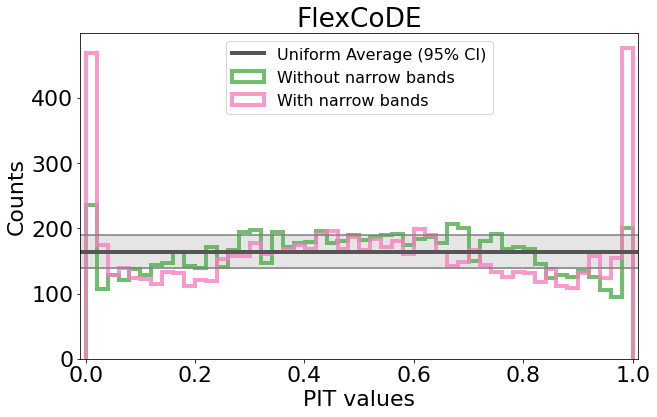

In [225]:
ci_quantity = (1-ci_level)/2
low_lim = binom.ppf(q=ci_quantity, n=n, p=1/n_bins)
upp_lim = binom.ppf(q=ci_level + ci_quantity, n=n, p=1/n_bins)

fig = plt.figure(figsize=[10,6])
plt.hist(pit_broad_flex, bins=n_bins,
            # edgecolor="white", 
            histtype="step",
            color= color_broad, 
            linewidth = 4,
            alpha=0.8,
            label="Without narrow bands")
plt.hist(pit_narrow_flex, bins=n_bins,
            # edgecolor="white", 
            histtype="step",
            color= color_narrow ,
            linewidth = 4,
            alpha=0.8,
            label="With narrow bands")
plt.axhline(y=low_lim, color='grey')
plt.axhline(y=upp_lim, color='grey')
plt.fill_between(x=np.linspace(-0.1, 1.1, 100),
                    y1=np.repeat(low_lim, 100),
                    y2=np.repeat(upp_lim, 100),
                color='grey', alpha=0.2)
plt.axhline(y=n/n_bins, label='Uniform Average (95% CI)', color='#555555', linewidth=4)
plt.legend(loc='upper center', prop={'size': 16})
plt.xlim(-0.01,1.01)
plt.xlabel("PIT values")
plt.ylabel("Counts")
plt.title("FlexCoDE")
plt.savefig(os.path.join(img_path, "pit_flexcode.png"))

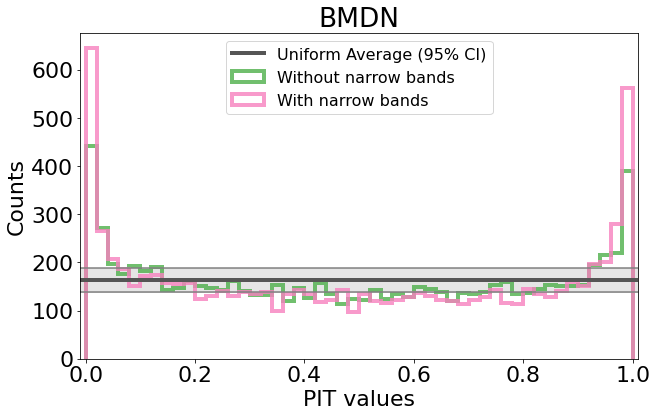

In [224]:
ci_quantity = (1-ci_level)/2
low_lim = binom.ppf(q=ci_quantity, n=n, p=1/n_bins)
upp_lim = binom.ppf(q=ci_level + ci_quantity, n=n, p=1/n_bins)

fig = plt.figure(figsize=[10,6])
plt.hist(pit_broad_bnn.PIT, bins=n_bins,
            # edgecolor="white", 
            histtype="step",
            color= color_broad, 
            linewidth = 4,
            alpha=0.8,
            label="Without narrow bands")
plt.hist(pit_narrow_bnn.PIT, bins=n_bins,
            # edgecolor="white", 
            histtype="step",
            color= color_narrow ,
            linewidth = 4,
            alpha=0.8,
            label="With narrow bands")
plt.axhline(y=low_lim, color='grey')
plt.axhline(y=upp_lim, color='grey')
plt.fill_between(x=np.linspace(-0.1, 1.1, 100),
                    y1=np.repeat(low_lim, 100),
                    y2=np.repeat(upp_lim, 100),
                color='grey', alpha=0.2)
plt.axhline(y=n/n_bins, label='Uniform Average (95% CI)', color='#555555', linewidth=4)
plt.legend(loc='upper center', prop={'size': 16})
plt.xlim(-0.01,1.01)
plt.xlabel("PIT values")
plt.ylabel("Counts")
plt.title("BMDN")
plt.savefig(os.path.join(img_path, "pit_bmdn.png"))